In [ ]:
import matplotlib.pyplot as plt
import numpy as nm
import pandas as pd
import math
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn import preprocessing as pre
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from rdkit.Chem.QED import qed

100%|██████████| 452/452 [00:04<00:00, 97.04it/s] 


  0%|          | 0/419 [00:00<?, ?it/s]

root mean squared error is  1.0378136547801826
r2 is 0.2354650381704706
std_dev is 0.520317840131091


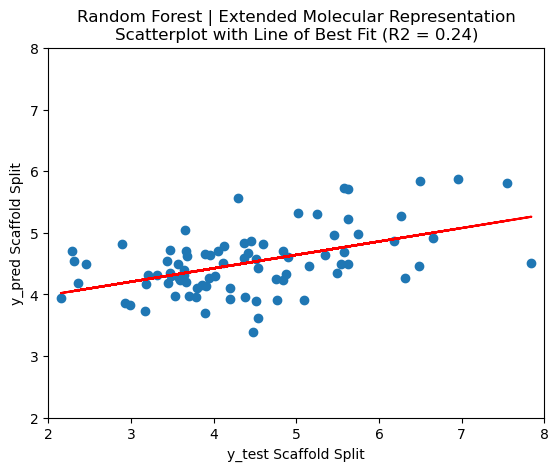

In [ ]:
# INPUT
folder = 'C:\\Users\\vswen\\Documents\\1. Biomedische Technologie\\BMT JAAR 5\\Kwart 4\\4. Data\\CTRPv2.0_2015_ctd2_ExpandedDataset\\'
experiment_id = 260
df_large = pd.read_csv(f"{folder}v20.data.curves_post_qc.txt", sep='\t')
df_smiles = pd.read_csv(f"{folder}v20.meta.per_compound.txt", sep='\t')

# BUNDELING
df_large=df_large[df_large['experiment_id'] == experiment_id]
df_summary = df_large[[ 'master_cpd_id','apparent_ec50_umol']]
extracted_col = df_smiles[["master_cpd_id","cpd_smiles"]]
df_summary_sorted = pd.merge(df_summary, extracted_col, on='master_cpd_id', how='left')

# MOL DESCRIPTORS
def mol_descriptor(smiles: list, scale: bool = True) -> nm.ndarray:
    X = []
    for smi in tqdm(smiles):
        m = Chem.MolFromSmiles(smi)
        x = nm.array([Descriptors.TPSA(m),
                      Descriptors.MolLogP(m),
                      Descriptors.MolWt(m),
                      Descriptors.FpDensityMorgan2(m),
                      Descriptors.HeavyAtomMolWt(m),
                      Descriptors.MaxPartialCharge(m),
                      Descriptors.MinPartialCharge(m),
                      Descriptors.NumRadicalElectrons(m),
                      Descriptors.NumValenceElectrons(m),
                      rdMolDescriptors.CalcFractionCSP3(m),
                      rdMolDescriptors.CalcNumRings(m),
                      rdMolDescriptors.CalcNumRotatableBonds(m),
                      rdMolDescriptors.CalcNumLipinskiHBD(m),
                      rdMolDescriptors.CalcNumLipinskiHBA(m),
                      rdMolDescriptors.CalcNumHeterocycles(m),
                      rdMolDescriptors.CalcNumHeavyAtoms(m),
                      rdMolDescriptors.CalcNumAromaticRings(m),
                      rdMolDescriptors.CalcNumAtoms(m),
                      qed(m)])
        X.append(x)

    if scale:
        return pre.MinMaxScaler().fit_transform(nm.array(X))

    return nm.array(X)


# EXTENDING DATAFRAME
smiles_column = df_summary_sorted['cpd_smiles']
Descriptors = mol_descriptor(smiles_column)

df_summary_sorted[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']] = Descriptors

# TRANSFORMATION EC50 VALUE
df_summary_sorted['ec50_mol'] = df_summary_sorted['apparent_ec50_umol'] / 1000000
df_summary_sorted['ec50_mol']=df_summary_sorted['ec50_mol'].replace(0, 1e-10)
df_summary_sorted['ec50_molair'] = df_summary_sorted['ec50_mol']/ df_summary_sorted['MolWt']

#SAVING RESULTS
df_summary_sorted.to_csv(f"{folder}v20.data.final_summary_{experiment_id}.txt", sep='\t', index=False)

#INPUT
df_complete = pd.read_csv(f"{folder}v20.data.final_summary_{experiment_id}.txt", sep='\t')
df_scaffold_split = df_complete[[ 'cpd_smiles','apparent_ec50_umol','MolWt','ec50_mol','ec50_molair']]

# LIST OF ALL SCAFFOLDS
smiles_list = df_scaffold_split['cpd_smiles']
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mols]
scaffold_smiles = [Chem.MolToSmiles(scaffold) for scaffold in scaffolds]
scaffold_smiles = list(map(str, scaffold_smiles))

# RETRIEVING MOLS OF SCAFFOLDS
molecule_scaffold = [Chem.MolFromSmiles(smile) for smile in scaffold_smiles]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024) for molecule in molecule_scaffold]

# LIST OF ALL UNIQUE SCAFFOLDS
def get_unique_scaffolds(scaffold_smiles):
    unique_scaffolds = []
    for scaffold in scaffold_smiles:
        if scaffold not in unique_scaffolds:
            unique_scaffolds.append(scaffold)
    return unique_scaffolds

list_unique_scaffolds=get_unique_scaffolds(scaffold_smiles)

# LOCATING SIMILAR SCAFFOLDS
location_scaffolds = defaultdict(list)
for scaffold in scaffold_smiles:
    location_scaffolds[scaffold].append(scaffold)

def location_similar_scaffolds(lijst):
    locations = defaultdict(list)
    for index, item in enumerate(lijst):
        if lijst.count(item) > 1:
            locations[item].append(index)
    return dict(locations)

locations_similar_scaffolds = location_similar_scaffolds(scaffold_smiles)

# NEW DATAFRAME FOR REACCURING SCAFFOLDS
df_scaffolds_grouped = pd.DataFrame(columns=['Compound', 'Scaffold', 'Recurring'])
rows=[]
symbol_mapping = {}  # Scaffold symbool dictionary
symbol_counter = 0  # Aantal unieke scaffolds

symbol_counter = 0
symbol_mapping = {}
rows = []

for i, compound in enumerate(smiles_list):
    scaffold = scaffold_smiles[i]

    if scaffold in locations_similar_scaffolds:
        if scaffold not in symbol_mapping:
            symbol_counter += 1
            symbol_mapping[scaffold] = symbol_counter

        recurring_symbol = symbol_mapping[scaffold]
        recurring = True
    else:
        recurring_symbol = 0
        recurring = False
    row = [compound, scaffold, recurring_symbol]
    rows.append(row)

df_scaffolds_grouped = pd.DataFrame(rows, columns=['cpd_smiles', 'spd_scaffold', 'recurring_scaffold'])

#Toevoegen van extra data die nodig is voor de modellen
df_scaffolds_grouped.insert(0,'ec50_molair',df_scaffold_split['ec50_molair'])
df_scaffolds_grouped.insert(1,'MolWt',df_scaffold_split['MolWt'])
df_scaffolds_grouped_sorted = df_scaffolds_grouped.sort_values('recurring_scaffold', ascending=False)

# OUTPUT
df_scaffolds_grouped_sorted.to_csv(f"{folder}scaffold_split_{experiment_id}.txt", sep='\t', index=False)

from tqdm.auto import tqdm
from rdkit.Chem.QED import qed
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn import preprocessing as pre
from typing import List

# Import data
complete_df = pd.read_csv(f"{folder}scaffold_split_{experiment_id}.txt", sep="\t")

 # Fingerprint aanmaken
## Morgan Fingerprint ECFP
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['cpd_smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]

# Transformatie EC50 | Instellen van limiten
complete_df['ec50_molair_transformed'] = -nm.log10(complete_df['ec50_molair'])
condition = (complete_df['ec50_molair_transformed'] < 2 ) | (complete_df['ec50_molair_transformed'] > 8)
complete_df=complete_df[~condition]

def mol_descriptor(smiles: List[str], scale: bool = True) -> nm.ndarray:
    X = []
    for smi in tqdm(smiles):
        m = Chem.MolFromSmiles(smi)
        x = nm.array([Descriptors.TPSA(m),
                      Descriptors.MolLogP(m),
                      Descriptors.MolWt(m),
                      Descriptors.FpDensityMorgan2(m),
                      Descriptors.HeavyAtomMolWt(m),
                      Descriptors.MaxPartialCharge(m),
                      Descriptors.MinPartialCharge(m),
                      Descriptors.NumRadicalElectrons(m),
                      Descriptors.NumValenceElectrons(m),
                      rdMolDescriptors.CalcFractionCSP3(m),
                      rdMolDescriptors.CalcNumRings(m),
                      rdMolDescriptors.CalcNumRotatableBonds(m),
                      rdMolDescriptors.CalcNumLipinskiHBD(m),
                      rdMolDescriptors.CalcNumLipinskiHBA(m),
                      rdMolDescriptors.CalcNumHeterocycles(m),
                      rdMolDescriptors.CalcNumHeavyAtoms(m),
                      rdMolDescriptors.CalcNumAromaticRings(m),
                      rdMolDescriptors.CalcNumAtoms(m),
                      qed(m)])
        X.append(x)

    if scale:
        return pre.MinMaxScaler().fit_transform(nm.array(X))

    return nm.array(X)


smiles_column = complete_df['cpd_smiles']
descriptors = mol_descriptor(smiles_column)

complete_df[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']] = descriptors

total_descriptors = complete_df[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']]

list_of_descriptor_names = ['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']

total_descriptors.shape
complete_df.shape

 # Plaats Unieke Scaffolds in aparte dataframe
df_unique_scaffolds = complete_df[complete_df['recurring_scaffold'] == 0]
df_unique_scaffolds = df_unique_scaffolds[['recurring_scaffold', 'ecfp_bit_vectors', 'ec50_molair_transformed','TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']].dropna()

total_descriptors = df_unique_scaffolds[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']]

# Extraheer de X en Y value van de nieuwe DF
x_unique = nm.array(df_unique_scaffolds['ecfp_bit_vectors'].tolist())
x_unique = nm.concatenate((x_unique, total_descriptors), axis=1)## X is de te gebruike compound waarde  | Fingerprint ECFP
y_unique = df_unique_scaffolds['ec50_molair_transformed'].values ## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed

# Plaats Repeterende Scaffolds in een aparte dataframe
df_grouped_scaffolds = complete_df[complete_df['recurring_scaffold'] > 0]
df_grouped_scaffolds = df_grouped_scaffolds[['ecfp_bit_vectors', 'ec50_molair_transformed', 'recurring_scaffold', 'TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']].dropna()

total_descriptors = df_grouped_scaffolds[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']]

# Extraheer de X, Y en Z value van de nieuwe DF
x_grouped = nm.array(df_grouped_scaffolds['ecfp_bit_vectors'].tolist()) ## X is de te gebruike compound waarde  | Fingerprint ECFP
x_grouped = nm.concatenate((x_grouped, total_descriptors), axis=1)
y_grouped = df_grouped_scaffolds['ec50_molair_transformed'].values ## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
z_grouped = df_grouped_scaffolds['recurring_scaffold'].values.tolist() ## Z is de indicator voor overeenkomstige scaffold groepen | Elke scaffoldgroup

size_train_set_grouped_scaffolds = len(z_grouped) * 0.8
size_train_set_grouped_scaffolds = int(size_train_set_grouped_scaffolds)

# Lijsten voor repeterende scaffold verdeling
x_train_grouped = []
y_train_grouped = []
x_test_grouped = []
y_test_grouped = []

# Verdeling moleculen op basis van scaffold groepen
for x in range(len(z_grouped)):
    if x < size_train_set_grouped_scaffolds:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    elif z_grouped[x] == z_grouped[x-1]:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    else:
        remaining = len(z_grouped)-x
        break

for x in range(remaining):
    x_test_grouped.append(x_grouped[x+remaining])
    y_test_grouped.append(y_grouped[x+remaining])

# X values omzetten in juiste vorm
x_train_grouped = [list(arr) for arr in x_train_grouped]
x_test_grouped = [list(arr) for arr in x_test_grouped]

# Random verdeling van unieke scaffolds
from sklearn.model_selection import train_test_split
x_train_unique,x_test_unique,y_train_unique,y_test_unique=train_test_split(x_unique,y_unique,test_size=0.2, random_state=42)

# X values omzetten in juiste vorm
x_train_unique = [list(arr) for arr in x_train_unique]
x_test_unique = [list(arr) for arr in x_test_unique]

# Samenvoegen van verdelingen unieke scaffolds en repeterende scaffolds
x_train_scaffolds = nm.concatenate((x_train_grouped, x_train_unique))
x_test_scaffolds = nm.concatenate((x_test_grouped, x_test_unique))

y_train_scaffolds = nm.concatenate((y_train_grouped, y_train_unique))
y_test_scaffolds = nm.concatenate((y_test_grouped, y_test_unique))

# Random Forest Model
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, min_samples_split=5,min_samples_leaf=4,max_depth=10,bootstrap=True)
regressor.fit(x_train_scaffolds,y_train_scaffolds)
y_pred_scaffolds = regressor.predict(x_test_scaffolds)


# Prestatie en Evaluatie
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Root Mean Squared Error
mse = mean_squared_error(y_test_scaffolds, y_pred_scaffolds)
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test_scaffolds,y_pred_scaffolds,1)
line = slope * nm.array(y_test_scaffolds)+ intercept
r2 = r2_score(y_test_scaffolds, y_pred_scaffolds)
print('r2 is', r2)

# Residuen berekenen
residuen_scaffold = y_test_scaffolds- y_pred_scaffolds

# Standard Deviation berekenen
std_dev = nm.std(y_pred_scaffolds)
print('std_dev is', std_dev)

# R2 Visualisatie
plt.scatter(y_test_scaffolds,y_pred_scaffolds)
plt.plot(y_test_scaffolds, line, color='red', label='line of current best fit')
plt.xlabel('y_test Scaffold Split')
plt.ylabel('y_pred Scaffold Split')
plt.xlim(2,8)
plt.ylim(2,8)
plt.title('Random Forest | Extended Molecular Representation\nScatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],    # aantal bomen in het ensemble
    'max_depth': [None, 5, 10],         # maximale diepte van elke boom
    'min_samples_split': [2, 5, 10],    # minimale aantal samples vereist om een knoop te splitsen
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False] # minimale aantal samples vereist om een bladknooppunt te zijn
}

# Voer de grid search uit met cross-validation
scoring='r2'
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(x_train_scaffolds, y_train_scaffolds)

# Bekijk de beste parameters en score
print("Beste parameters gevonden: ", grid_search.best_params_)
print("Beste score gevonden: ", grid_search.best_score_)